In [1]:
import pandas as pd
import numpy as np
from itertools import product
from ast import literal_eval
import seaborn as sns
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gp
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import tqdm
import matplotlib.colors as mcolors

In [2]:
pubs_path="../../data/nf_folder/Data/DerivedData/CleanedRawData/pubs_author_funder.csv"
convert_path="../../data/nf_folder/Data/AdditionalData/cntry_convert.xlsx"

In [3]:
pubs_author_funder = pd.read_csv(pubs_path)
pubs_author_funder['author_country'] = pubs_author_funder['author_country'].apply(literal_eval)
pubs_author_funder['funder_country'] = pubs_author_funder['funder_country'].apply(
    lambda x:literal_eval(x) if pd.notnull(x) else "Not-Funded")
pubs_author_funder.head()

/home/miaoli/conda/envs/funding/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,author_country,funder_country,discipline,year,rel_citation,citation
0,30507292,[Turkey],[Turkey],77,2009,0.485,6
1,30574690,"[United States, France]","[United States, United States, United States, ...",83,2009,0.703,9
2,30574691,[Russia],[Russia],83,2009,0.312,4
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",89,2009,0.137,1
4,30585097,"[Germany, Spain]",[Spain],89,2009,0.410,3


In [4]:
pubs_author_funder['author_distinct']=pubs_author_funder['author_country'].apply(lambda x:list(set(x)))
pubs_author_funder['funder_distinct']=pubs_author_funder['funder_country'].apply(
    lambda x:list(set(x)) if x!='Not-Funded' else 'Not-Funded')

## calculate the fundind ratio over year

In [5]:
pubs_df=pubs_author_funder.copy()

In [6]:
pubs_df = pubs_df[['id','author_distinct','funder_distinct','discipline','year']]
pubs_df.head()

,id,author_distinct,funder_distinct,discipline,year
0,30507292,[Turkey],[Turkey],77,2009
1,30574690,"[France, United States]",[United States],83,2009
2,30574691,[Russia],[Russia],83,2009
3,30585095,[Spain],[Spain],89,2009
4,30585097,"[Spain, Germany]",[Spain],89,2009


### measure whether the publication is authored by single country or by multiple countries

In [7]:
pubs_df['dome_authored']=pubs_df['author_distinct'].apply(lambda x: 1 if len(x)==1 else 0)

### measure whether the publication is funded by the author country

In [8]:
pubs_df=pubs_df.explode('author_distinct')
pubs_df.head()

,id,author_distinct,funder_distinct,discipline,year,dome_authored
0,30507292,Turkey,[Turkey],77,2009,1
1,30574690,France,[United States],83,2009,0
1,30574690,United States,[United States],83,2009,0
2,30574691,Russia,[Russia],83,2009,1
3,30585095,Spain,[Spain],89,2009,1


In [10]:
convert_df = pd.read_excel(convert_path)
euset = set(convert_df[convert_df.EU==1].Country.tolist())

In [11]:
def assign_fund(author,funders):
    label=0
    if "EU" in funders and author in euset:
        label = 1
    elif author in funders:
        label=1
    return label
pubs_df['fund']=pubs_df.apply(lambda x:assign_fund(x.author_distinct,x.funder_distinct),axis=1)

In [12]:
pubs_df.head()

,id,author_distinct,funder_distinct,discipline,year,dome_authored,fund
0,30507292,Turkey,[Turkey],77,2009,1,1
1,30574690,United States,[United States],83,2009,0,1
1,30574690,France,[United States],83,2009,0,0
2,30574691,Russia,[Russia],83,2009,1,1
3,30585095,Spain,[Spain],89,2009,1,1


In [13]:
dome_df=pubs_df[pubs_df.dome_authored==1]
dome_fund=dome_df.groupby(['author_distinct','fund']).size().reset_index(name='count')

In [14]:
dome_fund=dome_fund.pivot_table(index='author_distinct',columns='fund',values='count',fill_value=0)
dome_fund=dome_fund.rename(columns={0:'Not-Fund',1:'Fund'})
dome_fund=dome_fund.div(dome_fund.sum(axis=1), axis=0)
dome_fund=dome_fund.reset_index()

In [15]:
dome_fund.head()

fund,author_distinct,Not-Fund,Fund
0,Afghanistan,1.000000,0.000000
1,Albania,0.995086,0.004914
2,Algeria,0.918975,0.081025
3,Andorra,1.000000,0.000000
4,Angola,1.000000,0.000000


In [16]:
coll_fund=pubs_df[pubs_df.dome_authored==0]
coll_fund.head()

,id,author_distinct,funder_distinct,discipline,year,dome_authored,fund
1,30574690,United States,[United States],83,2009,0,1
1,30574690,France,[United States],83,2009,0,0
4,30585097,Spain,[Spain],89,2009,0,1
4,30585097,Germany,[Spain],89,2009,0,0
7,30585103,Ireland,[Ireland],89,2009,0,1


In [17]:
coll_fund=coll_fund.groupby(['author_distinct','fund']).size().reset_index(name='count')
coll_fund=coll_fund.pivot_table(index='author_distinct',columns='fund',values='count',fill_value=0)
coll_fund=coll_fund.rename(columns={0:'Not-Fund',1:'Fund'})
coll_fund=coll_fund.div(coll_fund.sum(axis=1), axis=0)
coll_fund=coll_fund.reset_index()

In [18]:
coll_fund.head()

fund,author_distinct,Not-Fund,Fund
0,Afghanistan,0.997305,0.002695
1,Albania,0.986234,0.013766
2,Algeria,0.914643,0.085357
3,Andorra,0.897059,0.102941
4,Angola,0.916488,0.083512


In [22]:
def plot_worldmap(ax, fig, basemap, data, plotcolumn, cmap, vmin, vmax,legend_title):
    """plot a basemap and color the country based on the column passed into
    """

    basemap.plot(ax=ax, linewidth=0.25, edgecolor="#8C8C8C", facecolor="#ffffff")
    data.plot(column=plotcolumn, cmap=cmap, vmin=vmin, vmax=vmax, ax=ax)
    ax.axis("off")
    
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="2%", pad=0.05)
    #sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    #sm._A = []
    #clb = fig.colorbar(sm, cax=cax)
    #clb.ax.set_title(legend_title)
    return fig, ax

In [23]:
world_geo=gp.read_file("../../data/nf_folder/Data/AdditionalData/world_map_shp/ne_50m_admin_0_countries.shp")

In [24]:
world_geo=gp.read_file("../../data/nf_folder/Data/AdditionalData/world_map_shp/ne_50m_admin_0_countries.shp")
world_geo=world_geo[['WoS','Code','geometry']]
world_geo=world_geo[world_geo.WoS!='Antarctica']
world_geo.head()

,WoS,Code,geometry
0,Zimbabwe,ZWE,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,Zambia,ZMB,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."
2,Yemen,YEM,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16..."
3,Vietnam,VNM,"MULTIPOLYGON (((104.06396 10.39082, 104.08301 ..."
4,Venezuela,VEN,"MULTIPOLYGON (((-60.82119 9.13838, -60.94141 9..."


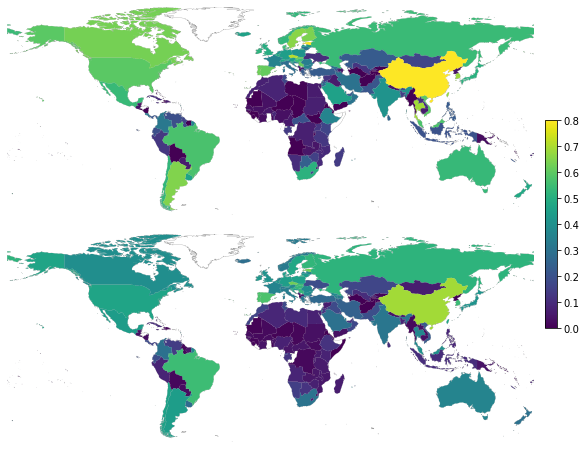

In [65]:
#fig,ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [4.95,4.95,0.1]},figsize=(20,6))
fig = plt.figure(figsize=(10,8))
gs = fig.add_gridspec(nrows=4, ncols=40)
ax0 = fig.add_subplot(gs[0:2, 0:39])
ax1 = fig.add_subplot(gs[1:3, 39:])
ax2= fig.add_subplot(gs[2:, 0:39])

plot_data=world_geo.merge(dome_fund,left_on='WoS',right_on='author_distinct')
plot_data=gp.GeoDataFrame(plot_data)
plot_worldmap(ax0, fig, world_geo, plot_data, 'Fund','viridis',0.0,0.8,'Proportion')
ax0.margins(0)

plot_data=world_geo.merge(coll_fund,left_on='WoS',right_on='author_distinct')
plot_data=gp.GeoDataFrame(plot_data)
plot_worldmap(ax2, fig, world_geo, plot_data, 'Fund','viridis',0.0,0.8,'Proportion')
ax2.margins(0)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=0.8))
fig.colorbar(sm,cax=ax1)
ax1.margins(0)
#ax1.set_title("Proportion of funded publication")
plt.savefig('results/funding_intensity.pdf',bbox_inches='tight')

In [15]:
fund_unit=pubs_author_funder[['funder_country','author_distinct']]
fund_unit=fund_unit[fund_unit.funder_country!='Not-Funded']
fund_unit.head(10)

,funder_country,author_distinct
0,[Turkey],[Turkey]
1,"[United States, United States, United States, ...","[France, United States]"
2,[Russia],[Russia]
3,"[Spain, Spain, Spain, Spain, Spain, Spain]",[Spain]
4,[Spain],"[Spain, Germany]"
5,[United States],[United States]
6,[United States],[United States]
7,[Ireland],"[United Kingdom, Ireland]"
8,[Japan],[Japan]
9,[Canada],"[United States, Canada]"


In [16]:
result_df=[]
for ind, row in tqdm.tqdm(fund_unit.iterrows()):
    funderdict=Counter(row['funder_country'])
    authorlist=set(row['author_distinct'])
    for k,v in funderdict.items():
        label=0
        if k in authorlist and len(authorlist)==1:
            label='dome'
        elif k in authorlist and len(authorlist)>1:
            label='coll'
        elif k not in authorlist:
            label='fore'
        result_df.append([k,v,label])

7739782it [07:10, 17982.36it/s]


In [17]:
unit_df=pd.DataFrame(result_df,columns=['cntry','count','type'])
unit_df=unit_df.groupby(['cntry','type'])['count'].sum().reset_index()
unit_df=unit_df.pivot_table(index='cntry',columns='type',values='count',fill_value=0)
unit_df.head()

type,coll,dome,fore
cntry,,,
Afghanistan,1,0,22
Albania,14,2,18
Algeria,1419,1019,169
Andorra,8,0,45
Angola,64,0,12


In [18]:
unit_df['ratio']=unit_df['dome']/unit_df['coll']
unit_df = unit_df.replace(to_replace=[np.inf,-np.inf],value=np.nan).dropna()
unit_df['ratio']=np.log10(unit_df['ratio'])
unit_df = unit_df.replace(to_replace=[np.inf,-np.inf],value=np.nan).dropna()

/home/miaoli/conda/envs/funding/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:
class MidpointNormalize(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [20]:
def plot_worldmaptest(ax, fig, basemap, data, plotcolumn, cmap, vmin,midpoint, vmax,legend_title):
    """plot a basemap and color the country based on the column passed into
    """
    norm = MidpointNormalize( midpoint = midpoint, vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []

    basemap.plot(ax=ax, linewidth=0.25, edgecolor="#8C8C8C", facecolor="#ffffff")
    data.plot(column=plotcolumn, cmap=cmap, norm=norm, ax=ax)
    ax.axis("off")
    
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    
    clb = fig.colorbar(sm, cax=cax)
    #clb.ax.set_title(legend_title)
    return fig, ax

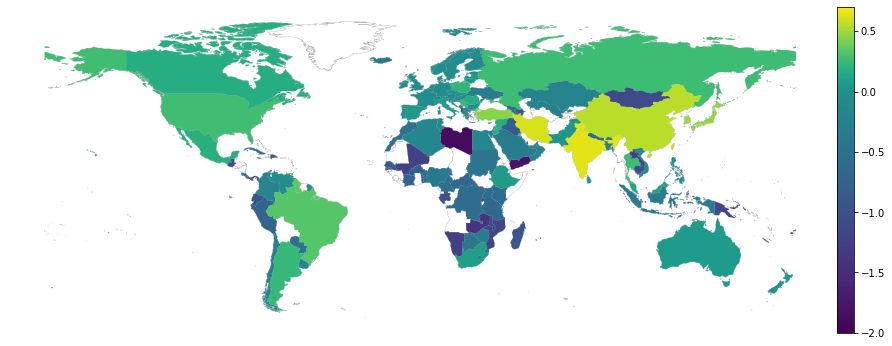

In [25]:
fig,ax = plt.subplots(figsize=(20,6))
plot_data=world_geo.merge(unit_df,left_on='WoS',right_on='cntry')
plot_data=gp.GeoDataFrame(plot_data)
plot_worldmaptest(ax, fig, world_geo, plot_data, 'ratio','viridis',-2,0,0.7,'Ratio')
plt.savefig('../../data/nf_folder/Figs/dome_coll_units.pdf',bbox_inches='tight')

In [8]:
pubs_df.head()

,id,author_distinct,funder_distinct,discipline,year,dome_authored
0,30507292,[Turkey],[Turkey],77,2009,1
1,30574690,"[United States, France]",[United States],83,2009,0
2,30574691,[Russia],[Russia],83,2009,1
3,30585095,[Spain],[Spain],89,2009,1
4,30585097,"[Spain, Germany]",[Spain],89,2009,0
